In [1]:
%pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Setup

In [2]:
import tensorflow as tf
from keras import layers, models
from keras.layers import preprocessing, RandomFlip, RandomRotation, RandomZoom
from keras.applications import EfficientNetV2B1
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras_tuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import numpy as np
from matplotlib import pyplot as plt
import pickle
import cv2


<ipython-input-2-b009c1b338a2>:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print('Using GPU:', physical_devices[0])
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print('No GPU found, using CPU instead.')


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# Load your dataset here
# Replace this with your actual dataset loading function
def load_dataset():
    # with open('C:\\Users\\rptej\\PycharmProjects\\CS6795_project\\project\\src\\data\\images_noNaN.pkl', 'rb') as f:
    #     data = pickle.load(f)

    # # Filter images with the correct shape and their corresponding points of interest
    # valid_data = [(row['image'], (row['first_x_fixation'], row['first_y_fixation']))
    #               for _, row in data.iterrows() if row['image'].shape == (960, 1280, 3)]

    # # Separate images and points of interest into two separate arrays
    # images, points_of_interest = zip(*valid_data)
    # images = np.stack(images, axis=0)
    # points_of_interest = np.array(points_of_interest)

    images = np.load('images_v2.npy')
    fixations = np.load('poi_v2.npy')

    return images, fixations



In [5]:
def data_generator(images, fixations, batch_size=32):
    num_samples = len(images)
    while True:
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            x_batch = images[start_idx:end_idx]
            y_batch = fixations[start_idx:end_idx]
            yield x_batch, y_batch


In [6]:



# Pre-process the images and points of interest
def preprocess_data(images, points_of_interest):
    # Resize and normalize images
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, (640, 480), interpolation=cv2.INTER_AREA)
        resized_images.append(resized_img)
    resized_images = np.array(resized_images).astype('float32') / 255.0

    # Scale points of interest
    original_image_size = np.array([1280, 960])
    new_image_size = np.array([640, 480])
    points_of_interest = (points_of_interest / original_image_size) * new_image_size

    return resized_images, points_of_interest



In [7]:
# Split the dataset into training and testing sets
def split_data(images, points_of_interest):
    x_train, x_test, y_train, y_test = train_test_split(images, points_of_interest, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test



In [8]:
# Create the transfer learning model
# Modify the create_model function to accept hyperparameters
def create_model(hp):
    base_model = tf.keras.applications.EfficientNetV2B2(include_top=False, weights='imagenet', input_shape=(480, 640, 3))
    
    # Unfreeze the last few layers
    num_unfrozen_layers = hp.Int('num_unfrozen_layers', min_value=1, max_value=15)
    for layer in base_model.layers[-num_unfrozen_layers:]:
        layer.trainable = True

    model = models.Sequential()

    # Add data augmentation
    # data_augmentation = tf.keras.Sequential([
    #     RandomFlip("horizontal_and_vertical"),
    #     RandomRotation(0.2),
    #     RandomZoom(0.2),
    # ])
    # model.add(data_augmentation)

    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    
    for _ in range(hp.Int('num_dense_layers', min_value=1, max_value=10)):
        model.add(layers.Dense(hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'))
        model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(2, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')), loss='mse', metrics=['mae'])
    return model



In [9]:
def load_model(model):
    if model == 1:
        return tf.keras.models.load_model('efficientnetb1_points_of_interest_savedmodel')
    else:
        return tf.keras.models.load_model('efficientnetb2_points_of_interest_savedmodel')



## Load dataset

In [10]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
import glob
import shutil
import zipfile
import hashlib

from tqdm import tqdm

In [12]:

# copy dataset
# new file copy code using shutil.copyfileobj
class TqdmFileWrapper:
    def __init__(self, file, progress_bar, md5=None):
        self.file = file
        self.progress_bar = progress_bar
        self.md5 = md5

    def read(self, size):
        buf = self.file.read(size)
        self.progress_bar.update(len(buf))
        if self.md5 is not None:
            self.md5.update(buf)
        return buf

    def write(self, buf):
        self.file.write(buf)
        self.progress_bar.update(len(buf))

    def close(self):
        self.file.close()

src_path = '/content/drive/MyDrive/src.rar'
dest_path = '/content/src.rar'

BLOCK_SIZE = 131072  # 128 KB

src_md5 = hashlib.md5()

# Downloading and verifying the source file
with open(src_path, 'rb') as src_file, open(dest_path, 'wb') as dst_file:
    file_size = os.path.getsize(src_path)
    with tqdm(total=file_size, unit='B', unit_scale=True, desc='Downloading') as pbar:
        wrapped_src_file = TqdmFileWrapper(src_file, pbar, md5=src_md5)
        shutil.copyfileobj(wrapped_src_file, dst_file)

Downloading: 100%|██████████| 1.43G/1.43G [00:14<00:00, 95.4MB/s]


In [13]:
!pip install unrar
!unrar x '/content/src.rar'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/src.rar

Extracting  poi_v2.npy                                                     0%  OK 
Extracting  transer_4_efficientnetb2.py                                    0%  OK 
Extracting  transfer_3_efficientnetb1.py                                   0%  OK 
Creating    efficientnetb1_points_of_interest_savedmodel              OK
Extracting  efficientnetb1_points_of_interest_savedmodel/fingerprint.pb       0%  OK 
Extracting  efficientnetb1_points_of_interest_savedmodel/keras_metadata.pb       0%  OK 
Extracting  efficientnetb1_points_of_interest_savedmodel/saved_model.pb       0%  OK 
Creating    efficientnetb1_points_of_interest_savedmodel/variables    OK
Extracting  efficientnetb1_points_of_interest_savedmodel/variables/variables.data

# Training

In [13]:
# Load and preprocess the dataset
images, points_of_interest = load_dataset()
# images, points_of_interest = preprocess_data(images, points_of_interest)

In [14]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = split_data(images, points_of_interest)


In [15]:
del images
del points_of_interest

In [16]:
# Create data generators for training and validation
batch_size = 8
train_gen = data_generator(x_train, y_train, batch_size=batch_size)
val_gen = data_generator(x_test, y_test, batch_size=batch_size)


In [20]:
# Initialize the Keras Tuner
# tuner = RandomSearch(
#     create_model,
#     objective='val_loss',
#     max_trials=10,
#     executions_per_trial=1,
#     directory='tuner_results',
#     project_name='efficientnetb2_points_of_interest_latest'
# )

from keras_tuner import Hyperband
tuner = Hyperband(
    create_model,
    objective='val_loss',
    max_epochs=25,
    factor=3,
    directory='tuner_results',
    project_name='efficientnetb2_points_of_interest_latest'
)

# Callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [ ]:
# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=25, batch_size=10, validation_data=(x_test, y_test), callbacks=[early_stopping, reduce_lr])


Trial 13 Complete [00h 04m 28s]
val_loss: 15876.0546875

Best val_loss So Far: 15796.27734375
Total elapsed time: 00h 40m 15s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
15                |15                |num_unfrozen_layers
3                 |1                 |num_dense_layers
224               |224               |units
0.5               |0.3               |dropout_rate
0.00090234        |0.00029683        |learning_rate
9                 |3                 |tuner/epochs
3                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
1                 |0                 |tuner/round
0000              |None              |tuner/trial_id

Epoch 4/9
241/241 [==============================] - 102s 152ms/step - loss: 19268.6758 - mae: 110.6486 - val_loss: 15741.5586 - val_mae: 101.6490 - lr: 9.0234e-04
Epoch 5/9
241/241 [==============================] - 30s 125ms/step - loss: 19031.6289 - mae: 110.3602 -

In [21]:
tuner.results_summary()

Results summary
Results in tuner_results/efficientnetb2_points_of_interest
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 05 summary
Hyperparameters:
num_unfrozen_layers: 4
num_dense_layers: 5
units: 256
dropout_rate: 0.2
learning_rate: 0.00013308311853362406
Score: 15637.044921875

Trial 01 summary
Hyperparameters:
num_unfrozen_layers: 1
num_dense_layers: 1
units: 224
dropout_rate: 0.4
learning_rate: 2.0902709378457082e-05
Score: 15686.46484375

Trial 09 summary
Hyperparameters:
num_unfrozen_layers: 6
num_dense_layers: 7
units: 224
dropout_rate: 0.2
learning_rate: 0.0007912445575623542
Score: 15721.1513671875

Trial 04 summary
Hyperparameters:
num_unfrozen_layers: 11
num_dense_layers: 4
units: 224
dropout_rate: 0.2
learning_rate: 0.0009770890999581843
Score: 15748.267578125

Trial 02 summary
Hyperparameters:
num_unfrozen_layers: 11
num_dense_layers: 4
units: 96
dropout_rate: 0.4
learning_rate: 2.8608252372199756e-05
Score: 16367.15625

Trial 06 summary
Hyper

In [26]:
best_hyperparams=tuner.get_best_hyperparameters(num_trials=1)[0]
display(best_hyperparams.values)

{'num_unfrozen_layers': 4,
 'num_dense_layers': 5,
 'units': 256,
 'dropout_rate': 0.2,
 'learning_rate': 0.00013308311853362406}

In [27]:
# Retrieve the best model from memory
# best_model = load_model(2)

# Retrieve best model from tuner 
best_model = tuner.get_best_models(num_models=1)[0]


In [32]:
# Train the best model
train_steps = len(x_train) // batch_size
val_steps = len(x_test) // batch_size
best_model.fit(train_gen, epochs=75, steps_per_epoch=train_steps, validation_data=val_gen, validation_steps=val_steps, callbacks=[early_stopping, reduce_lr])


Epoch 1/75
300/300 [==============================] - 98s 110ms/step - loss: 16755.2910 - mae: 103.6970 - val_loss: 15854.2695 - val_mae: 101.5352 - lr: 1.3308e-04
Epoch 2/75
300/300 [==============================] - 30s 101ms/step - loss: 16323.5381 - mae: 102.1044 - val_loss: 15973.2412 - val_mae: 101.8708 - lr: 1.3308e-04
Epoch 3/75
300/300 [==============================] - 31s 103ms/step - loss: 16371.5625 - mae: 102.2754 - val_loss: 15950.6182 - val_mae: 101.7692 - lr: 1.3308e-04
Epoch 4/75
300/300 [==============================] - 31s 102ms/step - loss: 16234.8457 - mae: 102.3072 - val_loss: 16254.3682 - val_mae: 102.5664 - lr: 1.3308e-04
Epoch 5/75
300/300 [==============================] - 31s 102ms/step - loss: 15995.8076 - mae: 100.6881 - val_loss: 16527.5586 - val_mae: 103.3693 - lr: 1.3308e-04
Epoch 6/75
300/300 [==============================] - 31s 102ms/step - loss: 15586.6562 - mae: 100.0437 - val_loss: 16213.2148 - val_mae: 102.4937 - lr: 1.3308e-04
Epoch 7/75
300/3

# Evaluate

In [33]:
# Evaluate the best model
mse, mae = best_model.evaluate(x_test, y_test)

print(f"\nMean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")


19/19 [==============================] - 3s 113ms/step - loss: 15876.8418 - mae: 101.6482

Mean Absolute Error (MAE): 101.64824676513672
Mean Squared Error (MSE): 15876.841796875


19/19 [==============================] - 4s 80ms/step


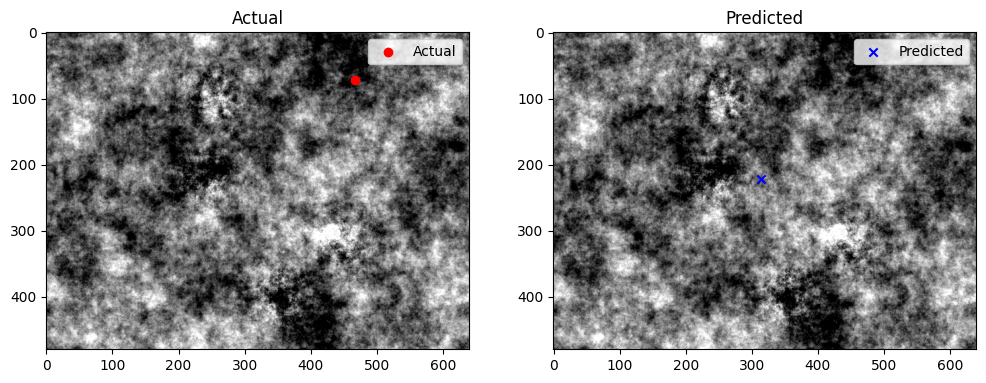

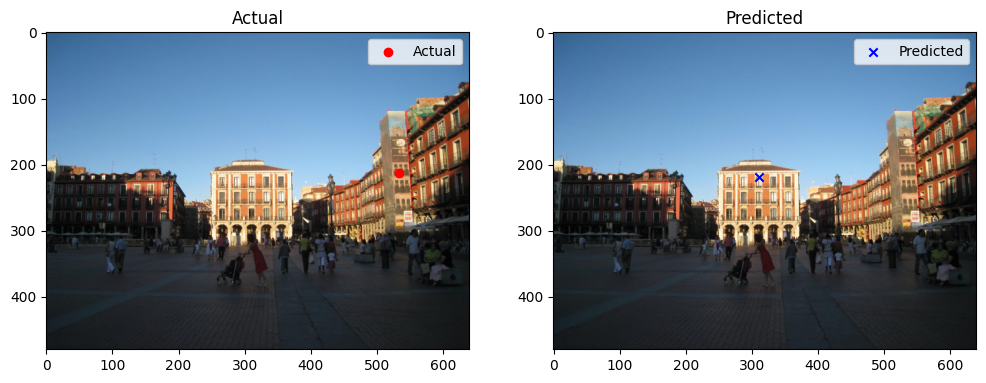

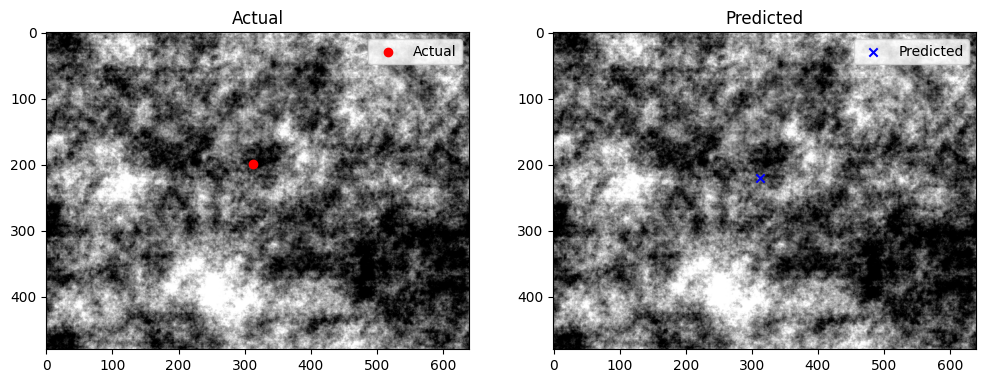

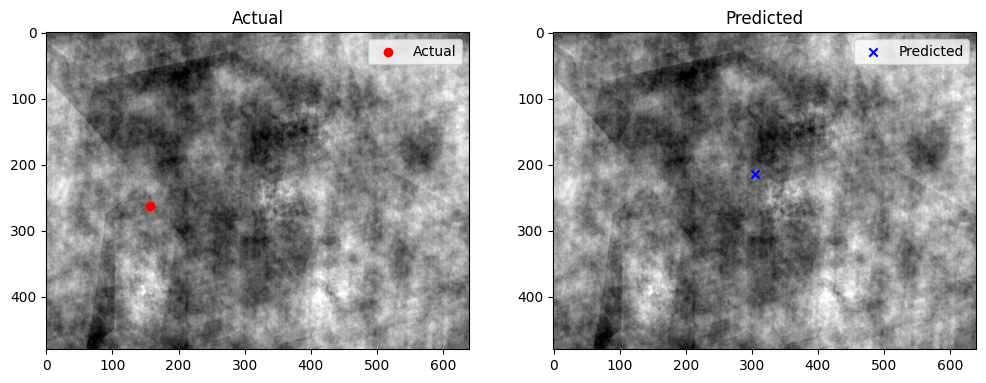

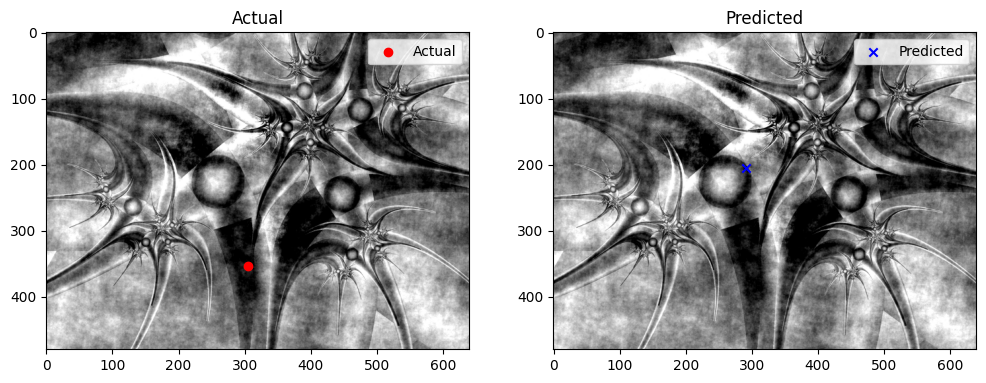

[[314.54056 221.16017]
 [310.50687 218.22752]
 [312.9981  220.08704]
 ...
 [323.7462  227.63657]
 [304.95612 214.43541]
 [312.2239  219.53127]]


In [34]:
# Make predictions
predictions = best_model.predict(x_test)

# Display a few test images with actual and predicted fixations
num_images_to_display = 5
for i in range(num_images_to_display):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Show the image with the actual point
    ax1.imshow(x_test[i])
    ax1.scatter(y_test[i, 0], y_test[i, 1], c='r', marker='o', label='Actual')
    ax1.set_title('Actual')
    ax1.legend()

    # Show the image with the predicted point
    ax2.imshow(x_test[i])
    ax2.scatter(predictions[i, 0], predictions[i, 1], c='b', marker='x', label='Predicted')
    ax2.set_title('Predicted')
    ax2.legend()

    plt.show()

print(predictions)


# Export

In [37]:
# Save the model using the SavedModel format
best_model.save("efficientnetb1_big_data_points_of_interest_savedmodel")


In [38]:
best_model.save('/content/drive/MyDrive/b1model_v2.h5')